In [1]:
import tensorflow as tf
import zipfile
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from PIL import Image
%matplotlib inline

In [2]:
import logging
logging.getLogger('tensorflow').disabled = True

In [3]:
base_dir = 'dataset'
dataset_dir = 'tmp'

os.makedirs(dataset_dir, exist_ok=True)

categories = [folder for folder in os.listdir(base_dir)]
unique_sizes = {}

for category in categories:
    os.makedirs(os.path.join(dataset_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, 'validation', category), exist_ok=True)

for category in categories:
    category_dir = os.path.join(base_dir, category)
    files = os.listdir(category_dir)

    train_files, validation_files = train_test_split(files, test_size=0.2, random_state=42)

    for file in train_files:
        src_path = os.path.join(category_dir, file)
        img = Image.open(src_path)
        w, h = img.size
        file_size = f"{w} * {h}"
        if file_size not in unique_sizes:
            unique_sizes[file_size] = 1
        else:
            unique_sizes[file_size] += 1
        dest_path = os.path.join(dataset_dir, 'train', category, file)
        shutil.copy(src_path, dest_path)

    for file in validation_files:
        src_path = os.path.join(category_dir, file)
        img = Image.open(src_path)
        w, h = img.size
        file_size = f"{w} * {h}"
        if file_size not in unique_sizes:
            unique_sizes[file_size] = 1
        else:
            unique_sizes[file_size] += 1
        dest_path = os.path.join(dataset_dir, 'validation', category, file)
        shutil.copy(src_path, dest_path)

for size, quantity in unique_sizes.items():
    print(f"{size} resolution: {quantity} images")

100 * 56 resolution: 16967 images
75 * 100 resolution: 4556 images
100 * 95 resolution: 23 images
100 * 100 resolution: 2866 images
100 * 98 resolution: 22 images
56 * 100 resolution: 1592 images
100 * 84 resolution: 28 images
87 * 100 resolution: 8 images
99 * 100 resolution: 27 images
100 * 90 resolution: 36 images
94 * 100 resolution: 16 images
95 * 100 resolution: 28 images
100 * 93 resolution: 29 images
100 * 96 resolution: 27 images
97 * 100 resolution: 19 images
100 * 97 resolution: 31 images
100 * 76 resolution: 18 images
100 * 92 resolution: 23 images
100 * 82 resolution: 21 images
100 * 88 resolution: 19 images
100 * 75 resolution: 543 images
100 * 85 resolution: 33 images
81 * 100 resolution: 19 images
100 * 80 resolution: 32 images
100 * 94 resolution: 32 images
93 * 100 resolution: 12 images
100 * 81 resolution: 24 images
84 * 100 resolution: 14 images
92 * 100 resolution: 12 images
100 * 91 resolution: 22 images
100 * 87 resolution: 17 images
100 * 77 resolution: 17 image

In [4]:
for category in categories:
  os.listdir(os.path.join(dataset_dir, 'train', category))

In [5]:
for category in categories:
  os.listdir(os.path.join(dataset_dir, 'validation', category))

In [6]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    shear_range=0.2,
                    vertical_flip=True,
                    fill_mode='nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_dir, 'train'),
        target_size=(100, 100),
        batch_size=8,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        os.path.join(dataset_dir, 'validation'),
        target_size=(100, 100),
        batch_size=8,
        class_mode='categorical')

Found 32400 images belonging to 27 classes.
Found 8100 images belonging to 27 classes.


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(27, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
            print("\nAkurasi pelatihan dan validasi telah mencapai >92%!")
            self.model.stop_training = True
callbacks = myCallback()

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/100
4050/4050 - 757s - loss: 1.1919 - accuracy: 0.6529 - val_loss: 0.4974 - val_accuracy: 0.8467 - 757s/epoch - 187ms/step
Epoch 2/100
4050/4050 - 438s - loss: 0.5090 - accuracy: 0.8496 - val_loss: 0.4035 - val_accuracy: 0.8777 - 438s/epoch - 108ms/step
Epoch 3/100
4050/4050 - 444s - loss: 0.3698 - accuracy: 0.8880 - val_loss: 0.3303 - val_accuracy: 0.9020 - 444s/epoch - 110ms/step
Epoch 4/100
4050/4050 - 456s - loss: 0.2969 - accuracy: 0.9066 - val_loss: 0.2850 - val_accuracy: 0.9147 - 456s/epoch - 113ms/step
Epoch 5/100

Akurasi pelatihan dan validasi telah mencapai >92%!
4050/4050 - 455s - loss: 0.2445 - accuracy: 0.9251 - val_loss: 0.2498 - val_accuracy: 0.9257 - 455s/epoch - 112ms/step


In [12]:
shutil.rmtree('tmp')

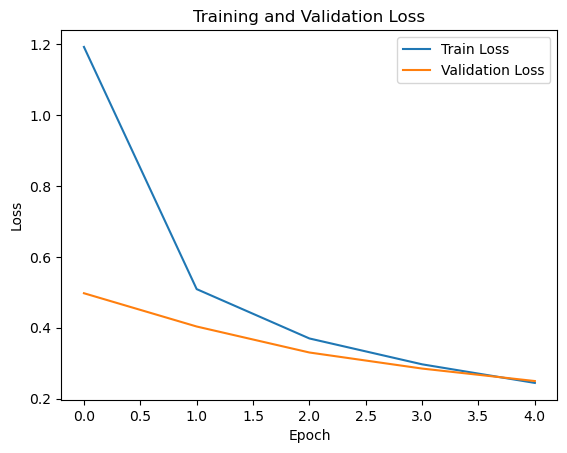

In [13]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

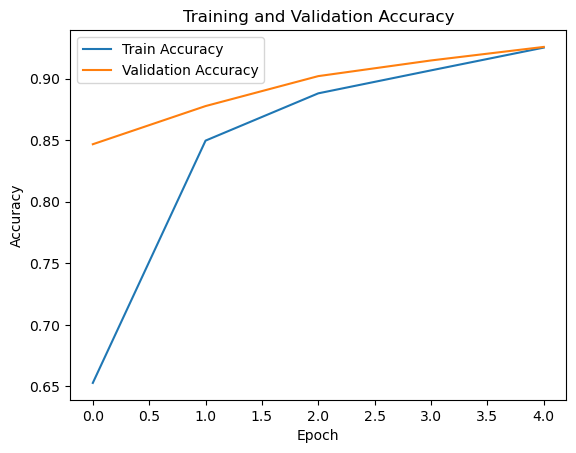

In [14]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()